## CELL IMAGES FOR DETECTING MALARIA

In [1]:
import warnings
warnings.filterwarnings('ignore') # to ignore any warning you might see in the code

### IMPORTING THE MALARIA DATASET

In [2]:
#importing dataset
no_malaria = "cell_images/Uninfected" #uninfected as no_malaria
malaria = "cell_images/Parasitized" #parasitized as malaria
image_size = 64  #pixel size per dimension

The uninfected cell images are imported into the 'no_malaria' dataframe
and the parasitized cell images are imported into the 'malaria' dataframe

### DATASET EXPLORATION

tdqm - Wrapping the output around the iterable with the tqdm library creates a smart progress bar, that shows the time elapsed and also the estimated time for the iterable

os- provides functions for creating and removing a directory, fetching its contents, changing and identifying the current directory.

100%|██████████████████████████████████████████████████████████████████████████| 13779/13779 [00:13<00:00, 1014.37it/s]


Text(0.5, 1.0, 'Infected malaria cells')

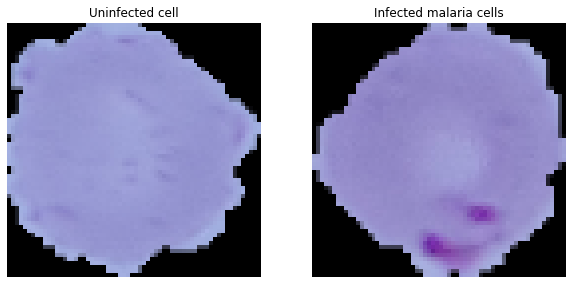

In [3]:
from tqdm import tqdm
import os  # used for IO operation like dealing with directories and files
import cv2  # this package for computer vision
import numpy as np
import matplotlib.pyplot as plt

m_data = [] 
label = []

# import, convert gray scale, and resize training set images for class 'messy':
for image in tqdm(os.listdir(no_malaria)): # listdir to list all files in that directory
    path = os.path.join(no_malaria, image) # folder of the parasitized sample images
    img = cv2.imread(path)  
    img = cv2.resize(img, (image_size, image_size))# resize the image size to 64 pixels * 64 pixels
    np_img=np.asarray(img) # convert it to numpy array for visualisations
    m_data.append(img)     # append the 'uninfected' images to the  main dataframe
    label.append(0)   #append '0' meaning no malaria
    
for image2 in tqdm(os.listdir(malaria)): 
    path = os.path.join(malaria, image2)# folder of the parasitized sample images
    img2 = cv2.imread(path) 
    img2 = cv2.resize(img2, (image_size, image_size)) # resize the image size to 64 pixels * 64 pixels 
    np_img2 =np.asarray(img2)
    m_data.append(img2)     # append the 'infected' images to the  main dataframe
    label.append(1)  #append '1' meaning no malaria


plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(np_img)
plt.axis('off')
plt.title("Uninfected cell")
plt.subplot(1, 2, 2)
plt.imshow(np_img2)
plt.axis('off')
plt.title("Infected malaria cells")

### DATA PRE-PROCESSING

In [4]:
#dimension of ARRAY dataset (64, 64,3)
m_data = np.array(m_data)
m_data.shape

(27558, 64, 64, 3)

In [5]:
#converting layers to categories and print shape
from tensorflow.keras.utils import to_categorical
label = to_categorical(np.array(label))
label.shape

(27558, 2)

In [6]:
#train and test set split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(m_data, label, test_size=0.2, random_state=24)

### MODEL BUILDING

###### CNN
- Convolutional Neural Network is a class of deep learning designed to learn large volumes of 2-Dimensional images and videos in robust manner.
- CNN eliminates the complexity of manual feature extraction and convolve learned features with input image

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#model building
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=2, activation='softmax')) #2 units for the two classes

#Model Compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
____

#### NB: 
1. A ReLU has output 0 if input is less than 0 but if input is greater than 0, output is equal to the input
2. Pooling layer is used in-between subsequent convolution layer to reduce the number of trainable parameters by retaining image information with reduced spatial size and Max pooling that picks the most dominant feature which is closer to the location.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
# using early stopping to control epochs by monitoring 'loss'
callbacks = EarlyStopping(monitor='loss', patience=3)

EarlyStopping is used to avoid overfitting when training a learner with an iterative method, such as gradient descent.

###### TRAINING
Multiple trails were performed to select optimal batch_size and epochs

In [9]:
np.random.seed(24)
history = model.fit(X_train, y_train, batch_size = 64, verbose = 1, epochs = 20, validation_data = (X_test, y_test), callbacks = [callbacks])

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 34s 2ms/sample - loss: 3.7534 - acc: 0.5413 - val_loss: 0.6726 - val_acc: 0.6020
Epoch 2/20
22046/22046 [==============================] - 34s 2ms/sample - loss: 0.6761 - acc: 0.5787 - val_loss: 0.6595 - val_acc: 0.6217
Epoch 3/20
22046/22046 [==============================] - 35s 2ms/sample - loss: 0.6631 - acc: 0.6042 - val_loss: 0.6499 - val_acc: 0.6355
Epoch 4/20
22046/22046 [==============================] - 35s 2ms/sample - loss: 0.6545 - acc: 0.6214 - val_loss: 0.6472 - val_acc: 0.6415
Epoch 5/20
22046/22046 [==============================] - 34s 2ms/sample - loss: 0.6449 - acc: 0.6317 - val_loss: 0.6471 - val_acc: 0.6246
Epoch 6/20
22046/22046 [==============================] - 34s 2ms/sample - loss: 0.6161 - acc: 0.6624 - val_loss: 0.4249 - val_acc: 0.8213
Epoch 7/20
22046/22046 [==============================] - 35s 2ms/sample - loss: 0.3362 - acc: 0.8803 - val_loss: 0.2

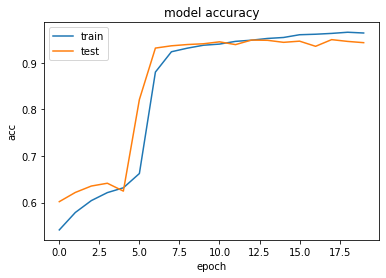

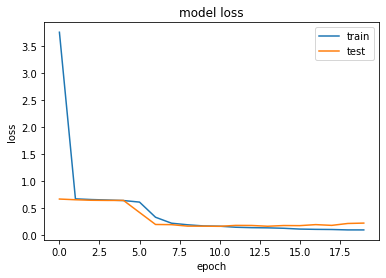

In [10]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

##### PERFROMANCE MEASURES

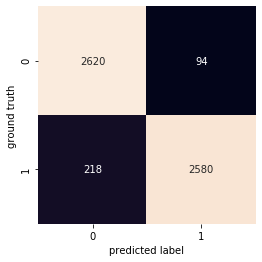

In [11]:
#confusion matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds = model.predict(X_test) #gets the prediction prob
preds = preds.argmax(axis=1)
y_true = y_test.argmax(axis=1)
mat = confusion_matrix(y_true, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('ground truth')
plt.show()

In [12]:
# classification report:
from sklearn.metrics import classification_report
y_true = y_test.argmax(axis=1)
print(classification_report(y_true,preds))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2714
           1       0.96      0.92      0.94      2798

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512



ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

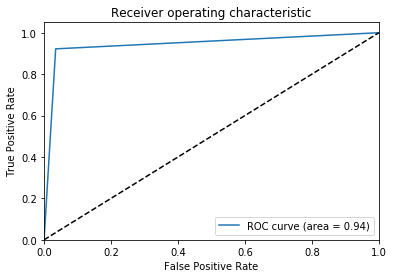

In [13]:
#ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, preds)
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

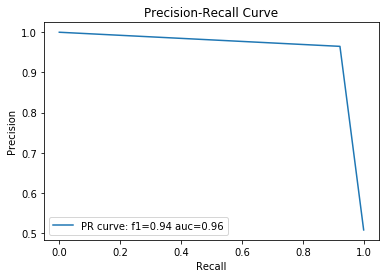

In [14]:
#pr curve
from sklearn.metrics import precision_recall_curve, f1_score, auc

precision, recall, _ = precision_recall_curve(y_true, preds)
f1, auc = f1_score(y_true, preds), auc(recall, precision)

# plot the precision-recall curves
plt.plot(recall, precision, label='PR curve: f1=%.2f auc=%.2f' % (f1, auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

### PRE-TRAINED MODELS (Transfer Learning)

##### VGG19

In [15]:
#importing the VGG19 model weights
from tensorflow.keras.applications import VGG19

VGG19_model = VGG19(include_top=False, weights="imagenet", input_shape=(64, 64, 3))

In [16]:
#Setting trainable to false since you are not gonna retrain the model but will use its pretrained weights instead
VGG19_model.trainable = False

In [17]:
#Creating model on top
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

inputs = Input(shape=(64, 64, 3))
x = VGG19_model(inputs, training=False)
x1 = GlobalAveragePooling2D()(x)
outputs = Dense(2, activation='softmax')(x1)
model_VGG19 = Model(inputs, outputs)
model_VGG19.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
_________________________________________________________________


In [18]:
from tensorflow.keras.optimizers import Adam

model_VGG19.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
np.random.seed(50)
history1 = model_VGG19.fit(X_train, y_train, batch_size = 64, verbose = 1, epochs = 5, validation_data = (X_test, y_test), callbacks = [callbacks])

Train on 22046 samples, validate on 5512 samples
Epoch 1/5
22046/22046 [==============================] - 186s 8ms/sample - loss: 0.7677 - acc: 0.8904 - val_loss: 0.4449 - val_acc: 0.9109
Epoch 2/5
22046/22046 [==============================] - 185s 8ms/sample - loss: 0.5237 - acc: 0.9066 - val_loss: 0.6017 - val_acc: 0.9009
Epoch 3/5
22046/22046 [==============================] - 186s 8ms/sample - loss: 0.5210 - acc: 0.9065 - val_loss: 0.5432 - val_acc: 0.9067
Epoch 4/5
22046/22046 [==============================] - 185s 8ms/sample - loss: 0.5547 - acc: 0.9087 - val_loss: 0.5476 - val_acc: 0.8875
Epoch 5/5
22046/22046 [==============================] - 185s 8ms/sample - loss: 0.5330 - acc: 0.9093 - val_loss: 0.3850 - val_acc: 0.9160


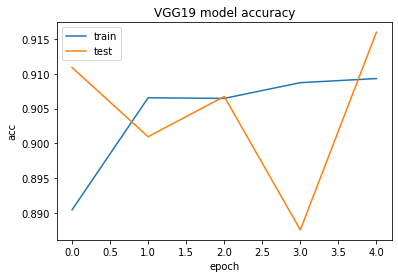

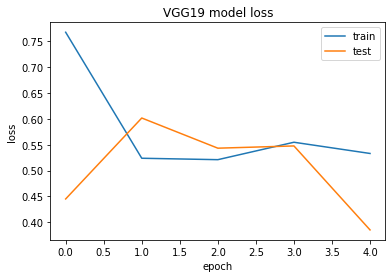

In [20]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('VGG19 model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('VGG19 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

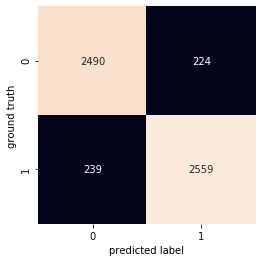

In [21]:
# plot confusion matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds1 = model_VGG19.predict(X_test)
preds1 = preds1.argmax(axis=1)
y_true1 = y_test.argmax(axis=1)
mat = confusion_matrix(y_true1,preds1)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('ground truth')
plt.show()

In [22]:
# classification report:
from sklearn.metrics import classification_report

print(classification_report(y_true1,preds1))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2714
           1       0.92      0.91      0.92      2798

    accuracy                           0.92      5512
   macro avg       0.92      0.92      0.92      5512
weighted avg       0.92      0.92      0.92      5512



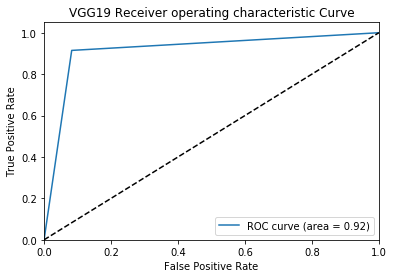

In [23]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true1, preds1)
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG19 Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

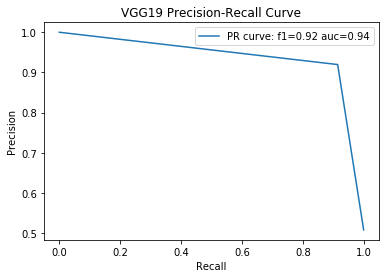

In [24]:
#pr curve
from sklearn.metrics import precision_recall_curve, f1_score, auc

precision, recall, _ = precision_recall_curve(y_true1, preds1)
f1, auc = f1_score(y_true1, preds1), auc(recall, precision)

# plot the precision-recall curves
plt.plot(recall, precision, label='PR curve: f1=%.2f auc=%.2f' % (f1, auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('VGG19 Precision-Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

#### ResNet50

In [25]:
#importing the RESNET50 model weights
from tensorflow.keras.applications import ResNet50

RN50_model = ResNet50(include_top=False, weights="imagenet", input_shape=(64, 64, 3))

In [26]:
# Setting trainable to false since you are not gonna retrain the model but will use its pretrained weights instead
RN50_model.trainable = False

In [27]:
#Creating model on top
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MaxPooling2D

inputs = Input(shape=(64, 64, 3))
x = RN50_model(inputs, training=False)
x1 = GlobalAveragePooling2D()(x)
outputs = Dense(2, activation='softmax')(x1)
model_RN50 = Model(inputs, outputs)

model_RN50.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
from tensorflow.keras.optimizers import Adam

model_RN50.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
np.random.seed(50)
history2 = model_RN50.fit(X_train, y_train, batch_size = 64, verbose = 1, epochs = 5, validation_data = (X_test, y_test), callbacks = [callbacks])

Train on 22046 samples, validate on 5512 samples
Epoch 1/5
22046/22046 [==============================] - 94s 4ms/sample - loss: 1.0234 - acc: 0.8546 - val_loss: 2.1668 - val_acc: 0.7734
Epoch 2/5
22046/22046 [==============================] - 95s 4ms/sample - loss: 0.6154 - acc: 0.8854 - val_loss: 0.4955 - val_acc: 0.8908
Epoch 3/5
22046/22046 [==============================] - 95s 4ms/sample - loss: 0.5705 - acc: 0.8875 - val_loss: 0.4965 - val_acc: 0.9116
Epoch 4/5
22046/22046 [==============================] - 95s 4ms/sample - loss: 0.6741 - acc: 0.8903 - val_loss: 1.1966 - val_acc: 0.8030
Epoch 5/5
22046/22046 [==============================] - 94s 4ms/sample - loss: 0.5970 - acc: 0.8998 - val_loss: 0.5956 - val_acc: 0.8937


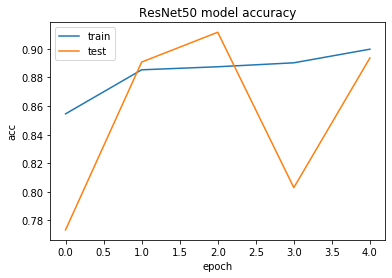

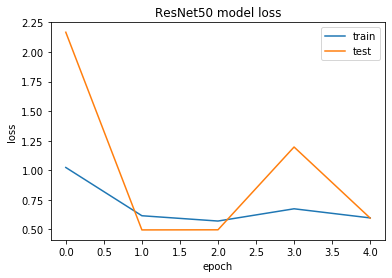

In [30]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('ResNet50 model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

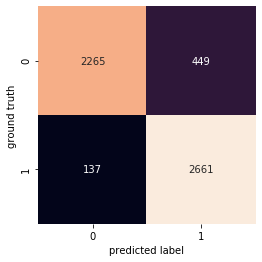

In [31]:
# plot confusion matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds2 = model_RN50.predict(X_test)
preds2 = preds2.argmax(axis=1)
y_true2 = y_test.argmax(axis=1)
mat = confusion_matrix(y_true2, preds2)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('ground truth')
plt.show()

In [32]:
# classification report:
from sklearn.metrics import classification_report

print(classification_report(y_true2,preds2))

              precision    recall  f1-score   support

           0       0.94      0.83      0.89      2714
           1       0.86      0.95      0.90      2798

    accuracy                           0.89      5512
   macro avg       0.90      0.89      0.89      5512
weighted avg       0.90      0.89      0.89      5512



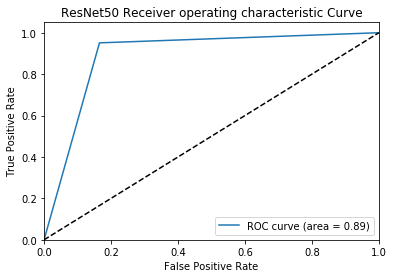

In [33]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true2, preds2)
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

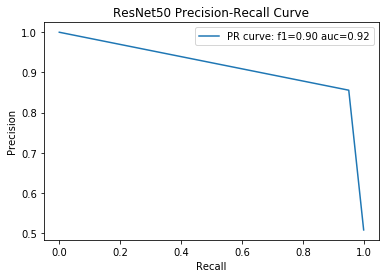

In [34]:
#pr curve
from sklearn.metrics import precision_recall_curve, f1_score, auc

precision, recall, _ = precision_recall_curve(y_true2, preds2)
f1, auc = f1_score(y_true2, preds2), auc(recall, precision)

# plot the precision-recall curves
plt.plot(recall, precision, label='PR curve: f1=%.2f auc=%.2f' % (f1, auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ResNet50 Precision-Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

##### CNN FINETUNING

In [35]:
from tensorflow import keras
import keras_tuner as kt

In [36]:
from tensorflow.keras.optimizers import Adam
# building the model and compiling it with the parameters to 
#optimise and search through using: 
# hp.choice('units', [8,16,32])
# hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Choice('filters', [8, 16, 32]), kernel_size=(3, 3), 
                     input_shape=(64, 64, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))
    
    hp_lR = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate = hp_lR), metrics=['accuracy'])
    return model

In [37]:
#using HYPERBAND from keras_tuner
tuner = kt.Hyperband(hypermodel= build_model, objective="val_acc", factor = 3, overwrite = True, max_epochs=10)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=3)

In [39]:
# starting the search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks =[callback])
best_model = tuner.get_best_hyperparameters(num_trials=3)[0]

Trial 9 Complete [00h 00m 49s]
val_acc: 0.94121915102005

Best val_acc So Far: 0.94121915102005
Total elapsed time: 00h 09m 58s
INFO:tensorflow:Oracle triggered exit


In [40]:
# fitting tuned model
model_tuned = tuner.hypermodel.build(best_model)
history3 = model_tuned.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, callbacks=[callbacks])

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 20s 901us/sample - loss: 1.0776 - acc: 0.5198 - val_loss: 0.6902 - val_acc: 0.5109
Epoch 2/20
22046/22046 [==============================] - 20s 896us/sample - loss: 0.6751 - acc: 0.5740 - val_loss: 0.6086 - val_acc: 0.7103
Epoch 3/20
22046/22046 [==============================] - 19s 880us/sample - loss: 0.4169 - acc: 0.8124 - val_loss: 0.2349 - val_acc: 0.9349
Epoch 4/20
22046/22046 [==============================] - 19s 866us/sample - loss: 0.2121 - acc: 0.9280 - val_loss: 0.1627 - val_acc: 0.9467
Epoch 5/20
22046/22046 [==============================] - 19s 870us/sample - loss: 0.1760 - acc: 0.9414 - val_loss: 0.1582 - val_acc: 0.9447
Epoch 6/20
22046/22046 [==============================] - 19s 883us/sample - loss: 0.1570 - acc: 0.9473 - val_loss: 0.1569 - val_acc: 0.9503
Epoch 7/20
22046/22046 [==============================] - 19s 874us/sample - loss: 0.1489 - acc: 0.9496 -

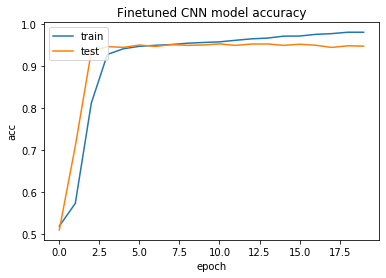

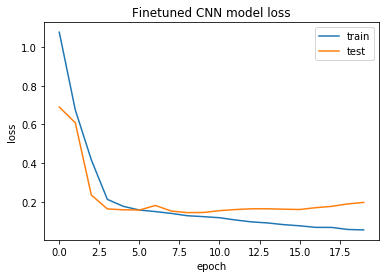

In [41]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Finetuned CNN model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Finetuned CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

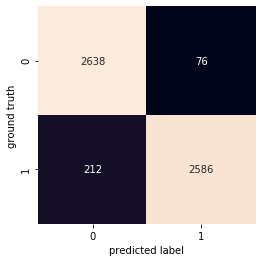

In [42]:
# plot confusion matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds3 = model_tuned.predict(X_test)
preds3 = preds3.argmax(axis=1)
y_true3 = y_test.argmax(axis=1)
mat = confusion_matrix(y_true3, preds3)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('ground truth')
plt.show()

In [43]:
# classification report:
from sklearn.metrics import classification_report

print(classification_report(y_true3,preds3))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2714
           1       0.97      0.92      0.95      2798

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



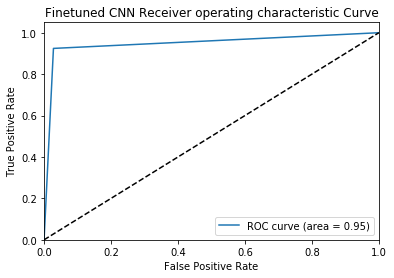

In [44]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true3, preds3)
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Finetuned CNN Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

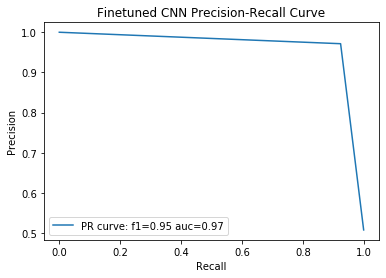

In [45]:
#pr curve
from sklearn.metrics import precision_recall_curve, f1_score, auc

precision, recall, _ = precision_recall_curve(y_true3, preds3)
f1, auc = f1_score(y_true3, preds3), auc(recall, precision)

# plot the precision-recall curves
plt.plot(recall, precision, label='PR curve: f1=%.2f auc=%.2f' % (f1, auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Finetuned CNN Precision-Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()